# Import packages

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))

from common import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, GRU, Bidirectional, RepeatVector, TimeDistributed, Dropout, BatchNormalization

tf.keras.utils.set_random_seed(RANDOM_STATE)
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

2022-07-13 15:51:44.032106: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-13 15:51:44.037649: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-13 15:51:44.037805: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# 1. Load dataset

In [5]:
train_data = pd.read_csv(join(PATH.input, "train_data.csv"))
sample_submission = pd.read_csv(join(PATH.input, "sample_submission.csv"))
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3859200 entries, 0 to 3859199
Data columns (total 13 columns):
 #   Column   Dtype  
---  ------   -----  
 0   TurbID   int64  
 1   Day      int64  
 2   Tmstamp  object 
 3   Wspd     float64
 4   Wdir     float64
 5   Etmp     float64
 6   Itmp     float64
 7   Ndir     float64
 8   Pab1     float64
 9   Pab2     float64
 10  Pab3     float64
 11  Prtv     float64
 12  Patv     float64
dtypes: float64(10), int64(2), object(1)
memory usage: 382.8+ MB


# 2. Preprocessing

## 1) Feature engineering

In [6]:
%%time

def full_preprocess(data):
    return preprocess(impute_data(generate_full_timestamp(data)))

train_data1 = full_preprocess(train_data)
train_data1

Number of Nan values: 0
CPU times: user 14.9 s, sys: 771 ms, total: 15.6 s
Wall time: 11.3 s


,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,Time_in_day,Time,X,Y,Etmp_abs,Wdir_adj,Wspd_cos,TSR1,TSR2,TSR3,Bspd1,Bspd2,Bspd3,RPM,Wspd_cube,P_max
0,1,1,00:00,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66,1,1,3349.8515,5939.23193,273.88,21.93,6.155045,2.605089,2.605089,2.605089,16.034441,16.034441,16.034441,16.034441,233.181313,0.857621
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66,2,2,3349.8515,5939.23193,273.88,21.93,6.155045,2.605089,2.605089,2.605089,16.034441,16.034441,16.034441,16.034441,233.181313,0.857621
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76,3,3,3349.8515,5939.23193,273.75,18.73,6.265462,2.605089,2.605089,2.605089,16.322087,16.322087,16.322087,16.322087,245.957079,0.900427
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53,4,4,3349.8515,5939.23193,273.67,20.18,6.419479,2.605089,2.605089,2.605089,16.723314,16.723314,16.723314,16.723314,264.544863,0.966892
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36,5,5,3349.8515,5939.23193,273.64,21.80,6.249246,2.605089,2.605089,2.605089,16.279842,16.279842,16.279842,16.279842,244.052275,0.892196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,200,23:10,4.86,4.68,9.04,10.40,174.39,0.01,0.01,0.01,-108.13,308.65,140,28796,11.3385,6713.46517,252.19,179.07,4.843796,2.745986,2.745986,2.745986,13.300998,13.300998,13.300998,13.300998,113.646913,0.455178
3859196,134,200,23:20,4.46,-4.00,8.79,10.33,179.76,0.01,0.01,0.01,-93.64,221.60,141,28797,11.3385,6713.46517,251.94,175.76,4.449136,2.745986,2.745986,2.745986,12.217265,12.217265,12.217265,12.217265,88.069787,0.352134
3859197,134,200,23:30,4.23,-0.08,8.74,10.22,172.35,0.01,0.01,0.01,-111.20,220.60,142,28798,11.3385,6713.46517,251.89,172.27,4.229996,2.745986,2.745986,2.745986,11.615510,11.615510,11.615510,11.615510,75.686746,0.300476
3859198,134,200,23:40,4.36,-6.12,8.64,10.10,172.35,0.01,0.01,0.01,-108.04,222.15,143,28799,11.3385,6713.46517,251.79,166.23,4.335151,2.745986,2.745986,2.745986,11.904266,11.904266,11.904266,11.904266,81.472834,0.329171


## 2) Feature selection

In [7]:
cols = ['TurbID', 'Time', 'Wspd', 'Pab1', 'Pab2', 'Pab3', 'Wspd_cos', 'RPM', 'Wspd_cube', 'P_max', 'Patv']
# cols = ['TurbID', 'Time', 'RPM', 'Bspd1', 'Bspd3', 'Bspd2', 'Wspd_cos', 'Wspd', 'Wspd_cube', 'P_max', 'Pab1', 'Pab2', 'Pab3', 'TSR1', 'TSR2', 'TSR3', 'Prtv', 'Patv']
train_data2 = train_data1[cols]
train_data2

,TurbID,Time,Wspd,Pab1,Pab2,Pab3,Wspd_cos,RPM,Wspd_cube,P_max,Patv
0,1,1,6.17,1.00,1.00,1.00,6.155045,16.034441,233.181313,0.857621,494.66
1,1,2,6.17,1.00,1.00,1.00,6.155045,16.034441,233.181313,0.857621,494.66
2,1,3,6.27,1.00,1.00,1.00,6.265462,16.322087,245.957079,0.900427,509.76
3,1,4,6.42,1.00,1.00,1.00,6.419479,16.723314,264.544863,0.966892,542.53
4,1,5,6.25,1.00,1.00,1.00,6.249246,16.279842,244.052275,0.892196,509.36
...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,28796,4.86,0.01,0.01,0.01,4.843796,13.300998,113.646913,0.455178,308.65
3859196,134,28797,4.46,0.01,0.01,0.01,4.449136,12.217265,88.069787,0.352134,221.60
3859197,134,28798,4.23,0.01,0.01,0.01,4.229996,11.615510,75.686746,0.300476,220.60
3859198,134,28799,4.36,0.01,0.01,0.01,4.335151,11.904266,81.472834,0.329171,222.15


## 3) Split data

In [34]:
IN_SEQ_LEN  = 2*144
OUT_SEQ_LEN = 2*144
STRIDE      = 2*144
SHUFFLE     = False
TEST_SIZE   = 2/200
BATCH_SIZE  = 32

In [35]:
%%time
train_x, train_y, val_x, val_y, test_x = make_train_val_test_data(train_data2, IN_SEQ_LEN, OUT_SEQ_LEN, STRIDE, SHUFFLE, TEST_SIZE)

100%|██████████| 134/134 [00:05<00:00, 22.71it/s]


Train data(X, y)     : (12730, 288, 9) (12730, 288, 9)
Validation data(X, y): (134, 288, 9) (134, 288, 9)
Test data(X)         : (134, 288, 9)
CPU times: user 6.92 s, sys: 235 ms, total: 7.16 s
Wall time: 6.04 s


## 4) Scaling

In [36]:
from sklearn.preprocessing import StandardScaler

scaler  = StandardScaler()
train_x = scaler.fit_transform(train_x.reshape(-1, train_x.shape[-1])).reshape(train_x.shape)
train_y = scaler.transform(train_y.reshape(-1, train_y.shape[-1])).reshape(train_y.shape)

val_x   = scaler.transform(val_x.reshape(-1, val_x.shape[-1])).reshape(val_x.shape)
val_y   = scaler.transform(val_y.reshape(-1, val_y.shape[-1])).reshape(val_y.shape)

test_x  = scaler.transform(test_x.reshape(-1, test_x.shape[-1])).reshape(test_x.shape)

## 5) Generate tensorflow-dataset

In [37]:
train_ds = generate_dataset(train_x, train_y, BATCH_SIZE, shuffle=True)
val_ds   = generate_dataset(val_x, val_y, BATCH_SIZE, shuffle=True)
test_ds  = generate_dataset(test_x, batch_size=1, shuffle=True)

# 3. Modeling

In [64]:
from tensorflow.keras.layers import LSTMCell, RNN


class FeedBack(keras.Model):
    def __init__(self, units, out_steps, num_features):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = LSTMCell(units)
        self.lstm_rnn  = RNN(self.lstm_cell, return_state=True)
        self.dense = Dense(num_features)
    def warmup(self, inputs):
        X, *state = self.lstm_rnn(inputs)
        prediction = self.dense(X)
        return prediction, state
    
    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)
        predictions.append(prediction)
        for n in range(1, self.out_steps):
            X = prediction
            X, state = self.lstm_cell(X, states=state, training=training)
            prediction = self.dense(X)
            predictions.append(prediction)
            
        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions
    

model = FeedBack(256, *train_x[0].shape)
optimizer = tf.optimizers.Adam()
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# 4. Training

In [65]:
plt.style.use('ggplot')

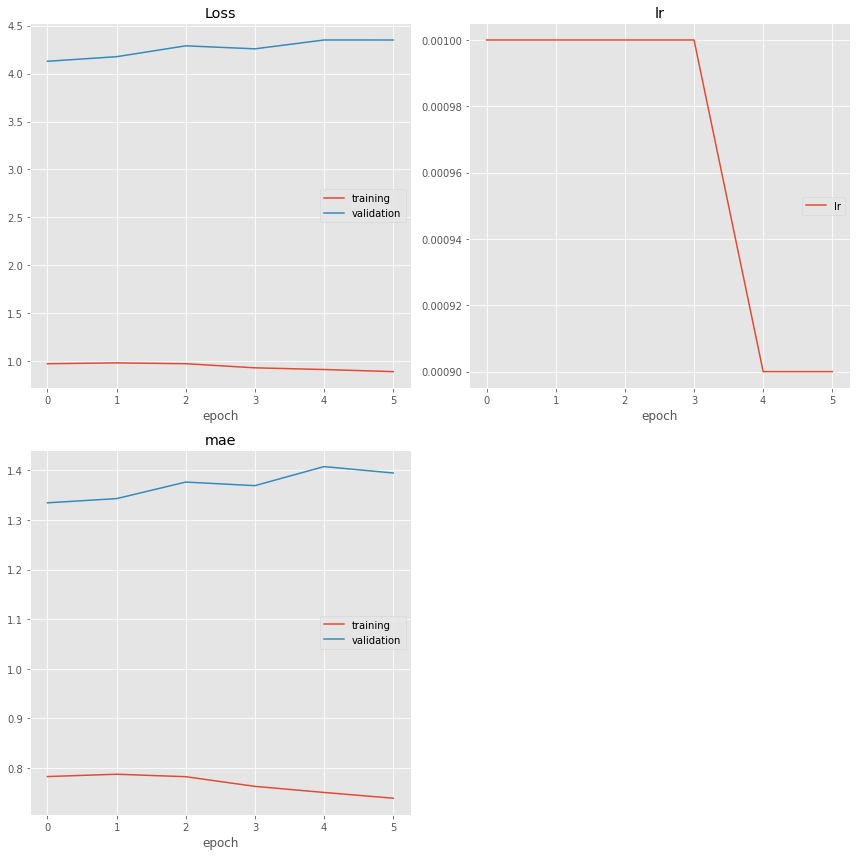

Loss
	training         	 (min:    0.892, max:    0.983, cur:    0.892)
	validation       	 (min:    4.129, max:    4.351, cur:    4.351)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
mae
	training         	 (min:    0.739, max:    0.787, cur:    0.739)
	validation       	 (min:    1.334, max:    1.408, cur:    1.395)
398/398 [==============================] - 102s 256ms/step - loss: 0.8916 - mae: 0.7389 - val_loss: 4.3506 - val_mae: 1.3946 - lr: 9.0000e-04


In [66]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from livelossplot import PlotLossesKeras

model.fit(train_ds, validation_data=val_ds, epochs=10,
          callbacks=[EarlyStopping(patience=5, restore_best_weights=True),
                     ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1),
                     PlotLossesKeras()]);

# 5. Check results

## 1) Training result

398/398 [==============================] - 26s 53ms/step


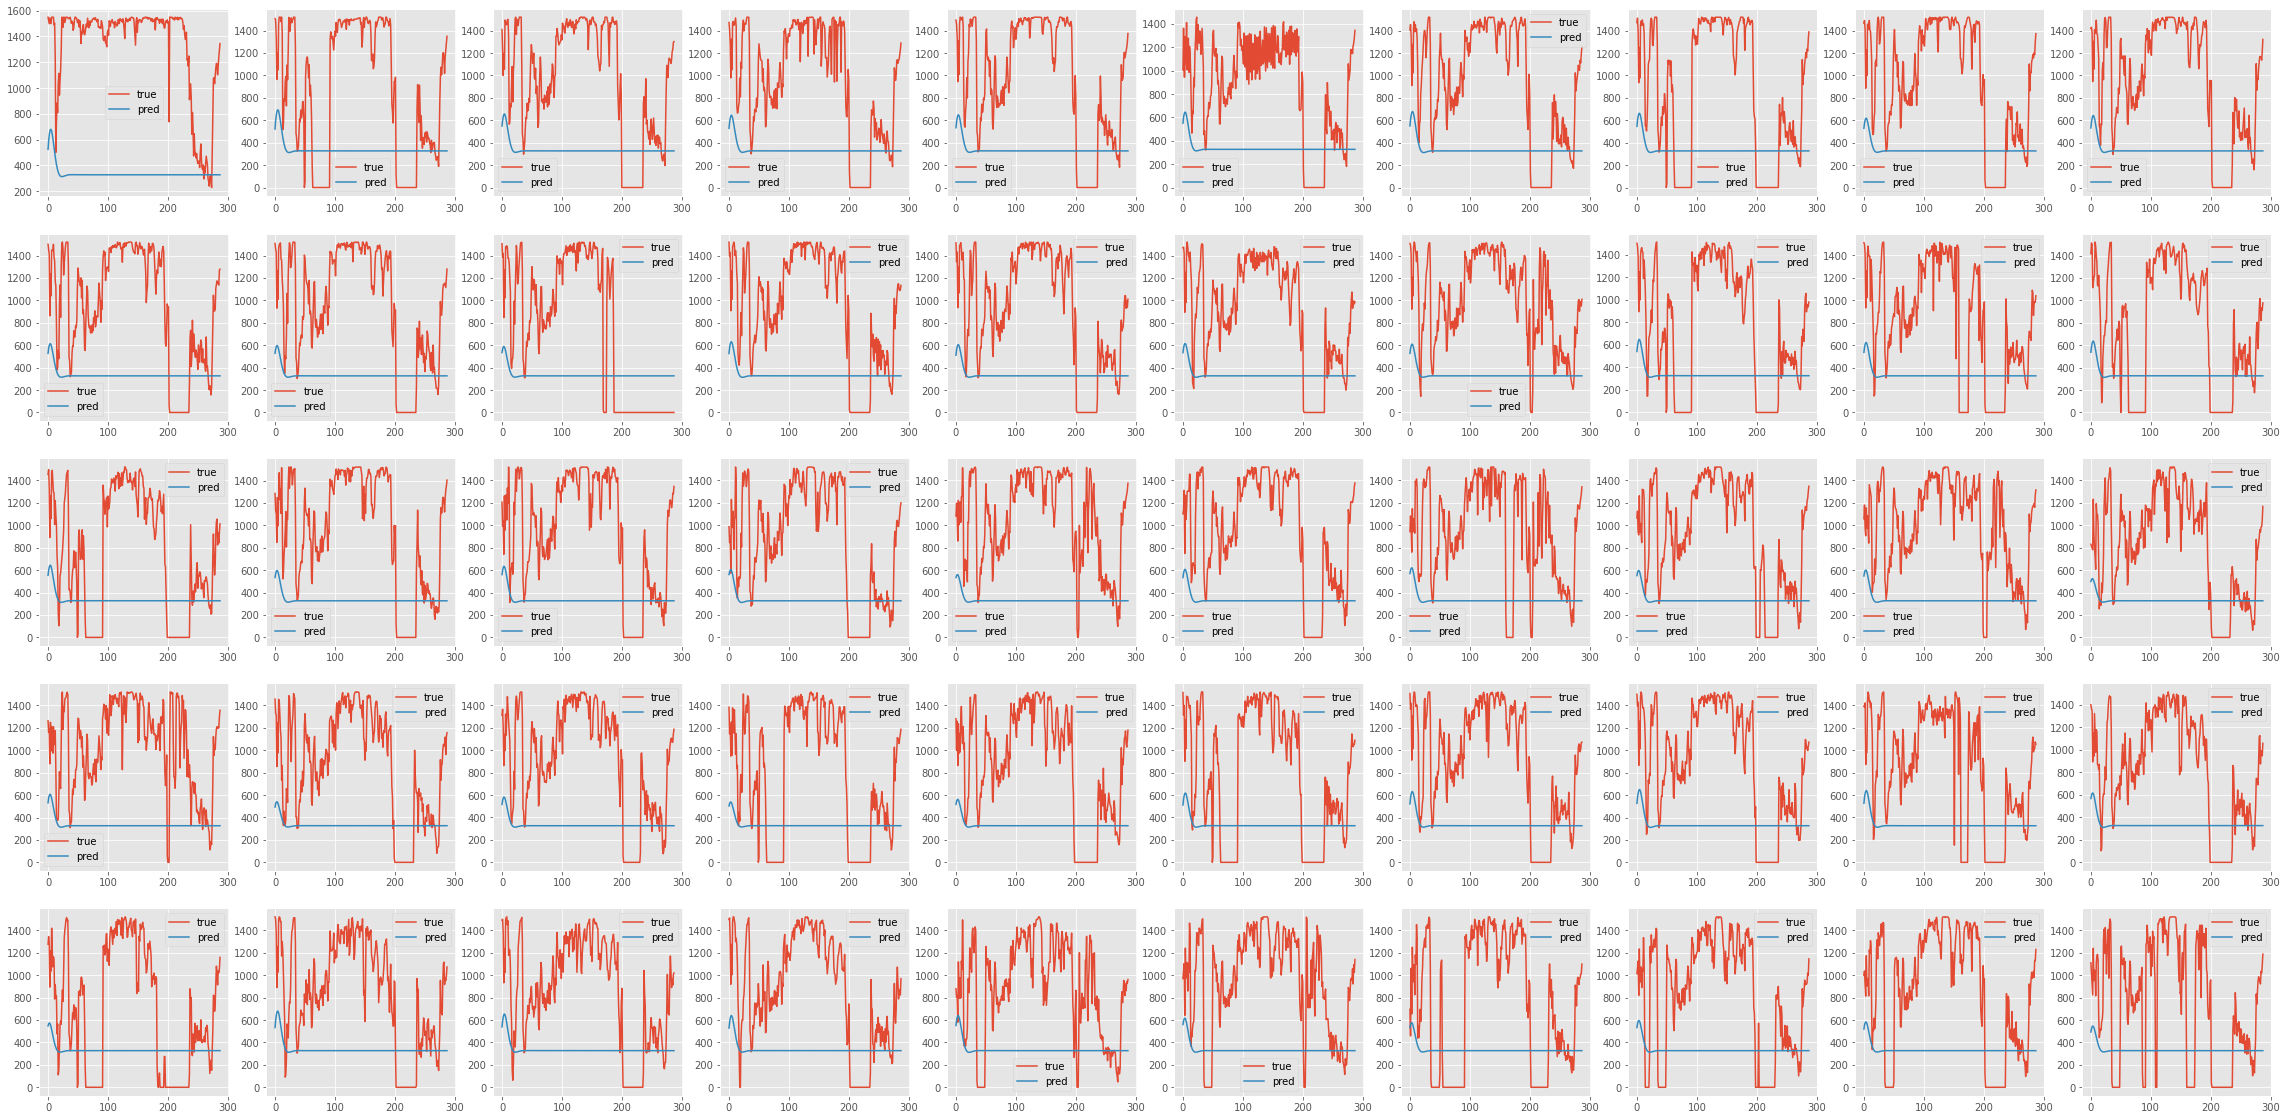

In [67]:
y_true = scaler.inverse_transform(train_y)[:, :, -1]
y_pred = scaler.inverse_transform(model.predict(train_x))[:, :, -1]
len_turb = len(y_true)//134

plt.style.use('ggplot')
fig, axes = plt.subplots(5, 10, figsize=(40, 20))
for i, ax in enumerate(axes.flatten()):  # i: turbID
    y_t = y_true[len_turb*i:len_turb*(i+1)].reshape(-1)[:144*2]
    y_p = y_pred[len_turb*i:len_turb*(i+1)].reshape(-1)[:144*2]
    ax.plot(y_t, label='true')
    ax.plot(y_p, label='pred')
    ax.legend()

## 2) Validation result

5/5 [==============================] - 0s 51ms/step


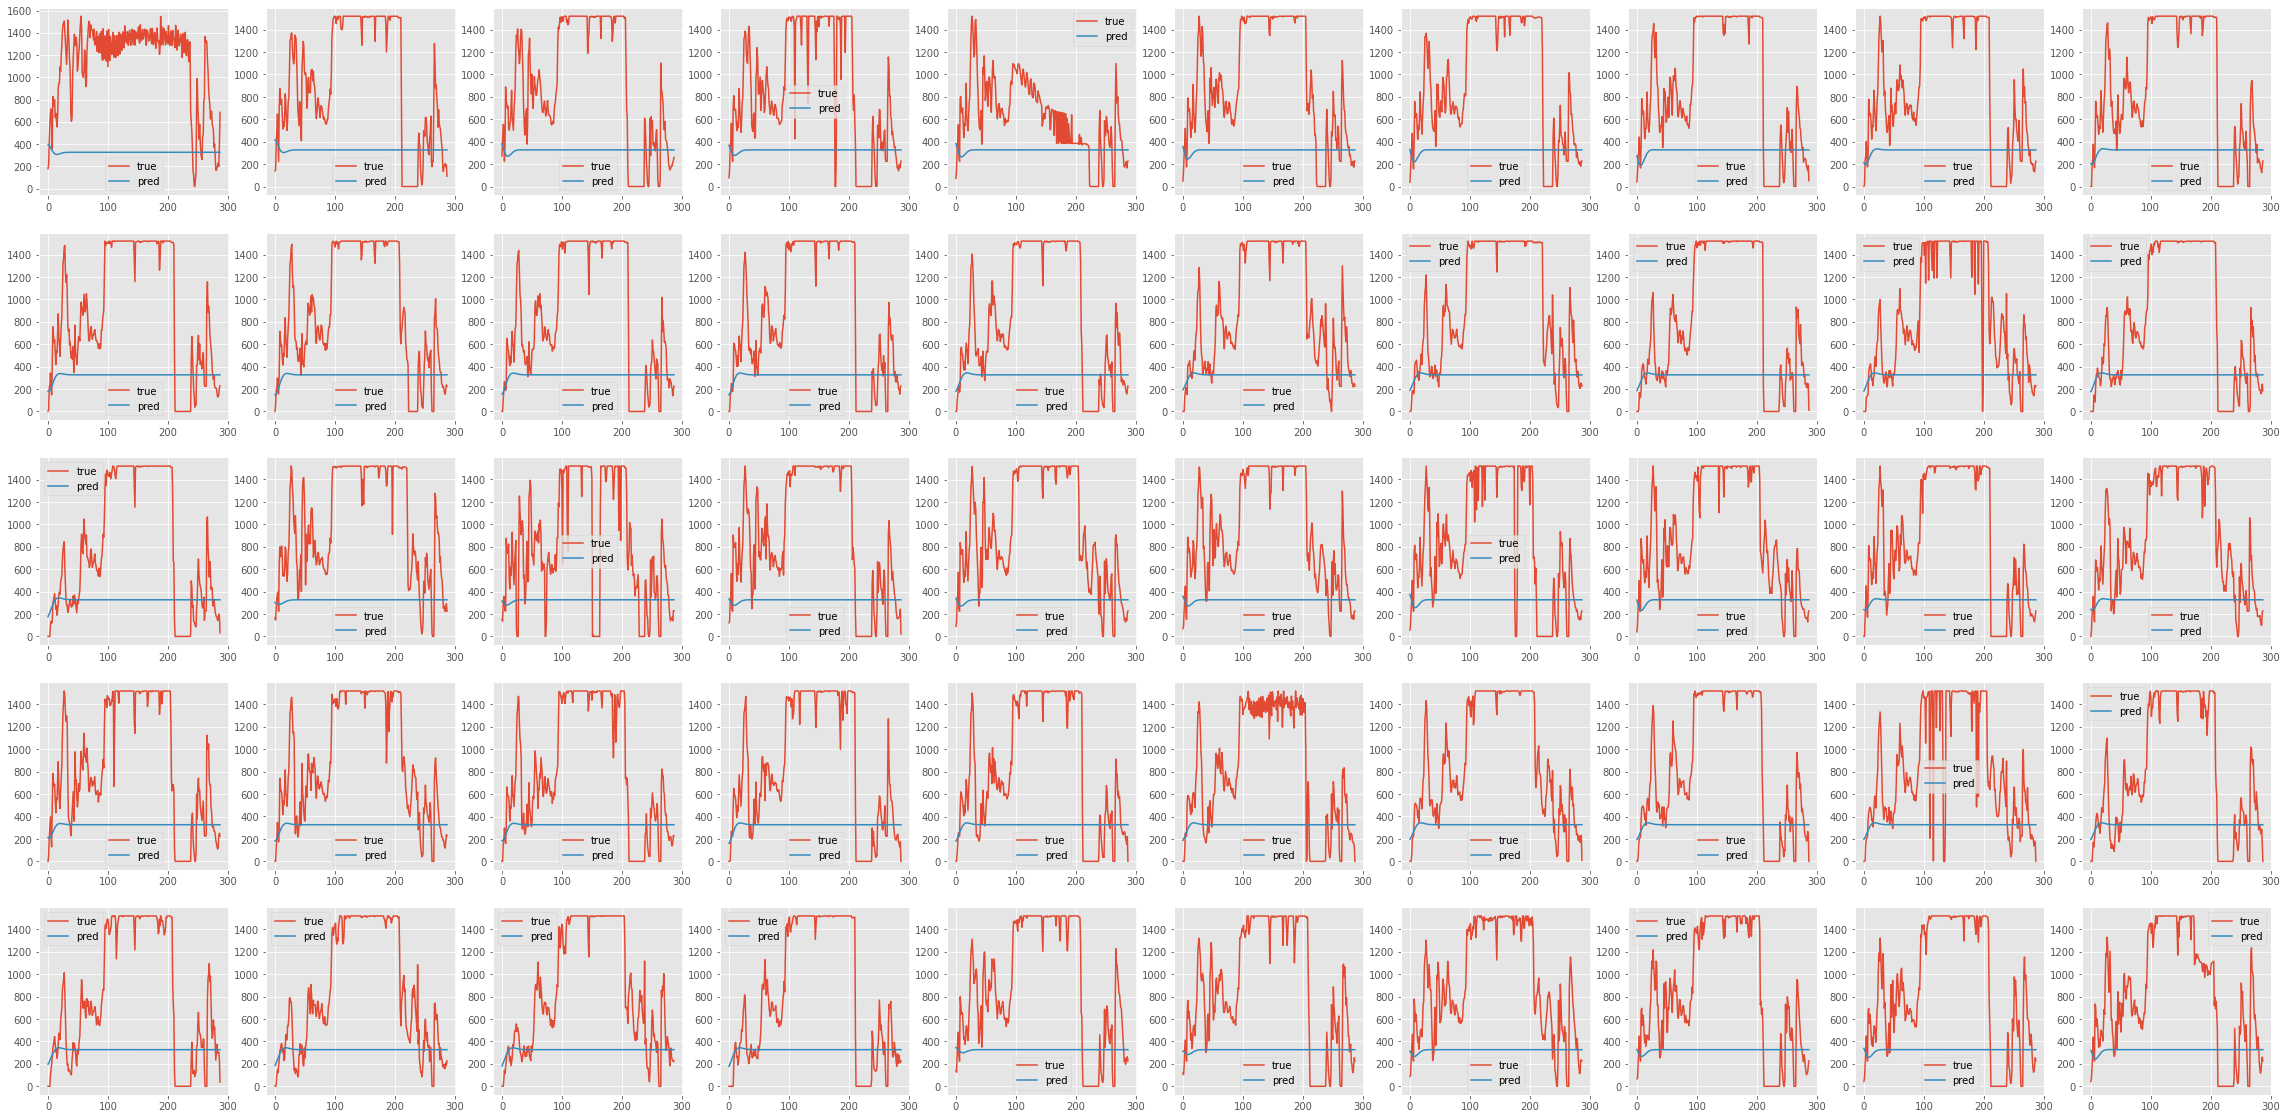

In [68]:
y_true = scaler.inverse_transform(val_y)[:, :, -1]
y_pred = scaler.inverse_transform(model.predict(val_x))[:, :, -1]
len_turb = len(y_true)//134

plt.style.use('ggplot')
fig, axes = plt.subplots(5, 10, figsize=(40, 20))
for i, ax in enumerate(axes.flatten()):  # i: turbID
    y_t = y_true[len_turb*i:len_turb*(i+1)].reshape(-1)[:144*2]
    y_p = y_pred[len_turb*i:len_turb*(i+1)].reshape(-1)[:144*2]
    ax.plot(y_t, label='true')
    ax.plot(y_p, label='pred')
    ax.legend()

# 6. Generate submission

In [69]:
sample_submission['Patv'] = scaler.inverse_transform(model.predict(test_x))[:, :, -1].reshape(-1)
sample_submission.to_csv(join(PATH.output, "proposed12.csv"), index=False)

5/5 [==============================] - 0s 55ms/step
